<a href="https://colab.research.google.com/github/jfgf11/Examen-2-Machine/blob/master/examen2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Examen 2




In [0]:
!pip install pyEDFlib

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=920093 sha256=49167aa3bea946454e57905faf571a41e5ab34ebe88a70bdaab6e9efb8e08b20
  Stored in directory: /root/.cache/pip/wheels/57/e3/8e/ce6236e9ada08b8ff91ef922c7418dbd66f1182dfbb22f8579
Successfully built pyEDFlib


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D

import pyedflib as pyedf
import numpy as np
import matplotlib.pyplot as ptl

#Lectura de los Datos

OSError: ignored

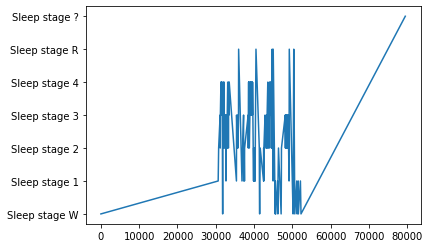

In [0]:
# Lectura del archivo de estados de sueño (etiquetas)
st_FileHypEdf = pyedf.EdfReader("SC4001EC-Hypnogram.edf")
print(st_FileHypEdf)

# Datos en ventanas de 30 segundos, 
#v_HypTime es el tiempo de inicio, v_HypDur es la duración en un estado específico (pueden ser varias ventanas),
# v_Hyp es la etiqueta.

v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations()

ptl.figure()
ptl.plot(v_HypTime, v_Hyp)

# Lectura de las señales s_SigNum señales con nombres v_Signal_Labels
st_FileEdf = pyedf.EdfReader("SC4001E0-PSG.edf")
print(st_FileEdf)
s_SigNum = st_FileEdf.signals_in_file
print(s_SigNum)
v_Signal_Labels = st_FileEdf.getSignalLabels()


# Conversion a segundos usando frecuencia de muestreo.
s_SigRef = 0
s_NSamples = st_FileEdf.getNSamples()[0]
s_FsHz = st_FileEdf.getSampleFrequency(s_SigRef)
print(s_NSamples)

# v_Sig = np.zeros((s_NSamples, 1))
v_Sig = st_FileEdf.readSignal(s_SigRef)
v_Time = np.arange(0, s_NSamples) / s_FsHz

s_WinSizeSec = 30
s_WinSizeSam = np.round(s_FsHz * s_WinSizeSec)


# plot de señales en ventanas de 30s
s_FirstInd = 0
ptl.figure()
while 1:
    s_LastInd = s_FirstInd + s_WinSizeSam
    if s_LastInd > s_NSamples:
        break

    ptl.plot(v_Time[s_FirstInd:s_LastInd], v_Sig[s_FirstInd:s_LastInd], linewidth=1)
    ptl.xlabel('Time (sec)')
    ptl.xlim(v_Time[s_FirstInd], v_Time[s_LastInd - 1])
    ptl.pause(0.5)

    s_FirstInd = s_LastInd

ptl.show()

In [0]:
print(st_FileHypEdf)
print(s_SigNum)


7


In [0]:
print(v_HypTime[-2])
print(v_Hyp[-2])

52260.0
Sleep stage W


In [0]:
79500/30*153

405450.0

In [0]:
v_Signal_Labels

NameError: ignored

#Entrenamiento del Modelo

In [0]:
#Ordenar estos parametros mejor. Quizas con un vector o algo asi para indicar cada capa de convolucion.
numFiltros1 = 10
tamFiltros1 = 5
tamMaxPooling1 = 3
numFiltros2 = 10
tamFiltros2 = 5
tamAveragePooling1 = 3

#Numero de clases
numClases = 7

modelo = Sequential()

#Esto corresponderia a la parte convolucional.
modelo.add(Conv1D(numFiltros1, tamFiltros1, activation = 'relu', input_shape = (3000,1)))
modelo.add(MaxPooling1D(tamMaxPooling1))
modelo.add(Conv1D(numFiltros2, tamFiltros2, activation = 'relu'))
modelo.add(AveragePooling1D(tamAveragePooling1))

#Esto corresponderia a la parte de red neuronal normalita. (Puse cualquier cosa por ahora)
modelo.add(Dense(20, activation = 'relu'))
modelo.add(Dense(numClases, activation = 'softmax'))

modelo.summary()